# Accelerated EFTofLSS predictions with `EFTEMU`

In this notebook we introduce the `EFTEMU`. A collection of component emulators included with `matryoshka`. The purpose of the `EFTEMU` is to accelerate EFTofLSS analyses. The emulator has been trained to predict the monopole $P_0$ and quandrupole $P_2$ returned by [PyBird](https://github.com/pierrexyz/pybird). For further details see Donald-McCann et al ([2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false)) and the accompanying GitHub [repository](https://github.com/JDonaldM/matryoshka_II_paper).

## General usage and prediction accuracy.

We start by importing all the modules required for this example.

In [1]:
# matryoshka modules
import matryoshka.eft_funcs as MatEFT
import matryoshka.halo_model_funcs as MatHM
import matryoshka.emulator as MatEmu
import matryoshka.plot as MatPlt

# Needed fro inference example
from scipy.optimize import minimize
from scipy.stats import norm
import zeus

# General imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Make reproducible
np.random.seed(42)

Next we load the cosmologies that correspond to the train and test sets for `EFTEMU`. These training samples were chosen to overlap the [Aemulus](https://aemulusproject.github.io) and [AbacusSummit](https://abacussummit.readthedocs.io/en/latest/) simulation samples (see section 2 of Donald-McCann et al. [2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false)), and were generated using the `matryoshka.training_funcs.Resampler` class. **All data used in this notebook is available in the accompanying repository of Donald-McCann et al. [2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false), which can be found [here](https://github.com/JDonaldM/matryoshka_II_paper).**

It should be noted that these cosmological parameters are the **only** input for the NNs that the `EFTEMU` is based on.
In equation 10 of D'Amico et al. ([2019](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005)) they write the power spectrum as a sum of terms that are bias independant. Training the emulator to predict these bias independant terms rather than $P_0$ or $P_2$ directly is advantageous because it greatly reduces the dimensionality of the input.

In [2]:
# Define path to the data in the matryoshka_II_paper
# https://github.com/JDonaldM/matryoshka_II_paper
data_dir = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/data/"
cosmos = np.load(f"{data_dir}training/cosmologies/eft_cosmologies_noDQ1.npy")

Next we initalise `EFTEMU` for $P_0$ and $P_2$. By default this will load the version of the `EFTEMU` presented in Donald-McCann et al. ([2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false)).

In [3]:
P0_emu = MatEmu.EFT(
    multipole=0, # Multipole order
    redshift=0.61
)

P2_emu = MatEmu.EFT(
    multipole=2,
    redshift=0.61
)

2023-11-03 13:45:05.499008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can now make predictions for the multipoles with the `EFTEMU` via the `.emu_predict()` method. If instead we want to make predictions for the individual kernels of the EFTofLSS model, predictions can be made with the individual component emulators of the `EFTEMU` (see section 3 of Donald-McCann et al. [2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false) for details). Each component emulator is stored as an attribute that has the same `.emu_predict()` method.

For now we consider the case in which the `EFTEMU` is being used to make predictions for the multipoles. We load the training and test sets for `EFTEMU` so we can have a look at the prediction accuracy.

In [4]:
# Training and test data is stored in the same array.
# Seperate arrays for each of the componenets and for each multipole.
P110_array = np.load(f"{data_dir}training/z0.61/P110/P110_array-z0.61_noDQ1_optiresum-False.npy")
Ploop0_array = np.load(f"{data_dir}training/z0.61/Ploop0/Ploop0_array-z0.61_noDQ1_optiresum-False.npy")
Pct0_array = np.load(f"{data_dir}training/z0.61/Pct0/Pct0_array-z0.61_noDQ1_optiresum-False.npy")
P112_array = np.load(f"{data_dir}training/z0.61/P112/P112_array-z0.61_noDQ1_optiresum-False.npy")
Ploop2_array = np.load(f"{data_dir}training/z0.61/Ploop2/Ploop2_array-z0.61_noDQ1_optiresum-False.npy")
Pct2_array = np.load(f"{data_dir}training/z0.61/Pct2/Pct2_array-z0.61_noDQ1_optiresum-False.npy")

# Test data is located with ids.
test_id = np.load("/Users/jamie/Desktop/GitHubProjects/Matryoshka/matryoshka-data/EFTv2/z0.61/split/test.npy")

We are not so interested in the prediction accuracy of the bias independant terms themselves but rather the multipoles $P_0$ and $P_2$. This means that we need to generate multipoles from the bias free componenets, and this means we need to decide what nuisance parameters we should use.

For this notebook we simply take random draws from the priors that were used in D'Amico et al. ([2019](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005)) (equation 35). Randomly selecting nuiscance parameters like this will lead to some strange predictions for $P_0$ and $P_2$. These predictions may not be physical. However, this is the simplest way of generating nuisance parameters so we don't concern ourselves with this for this example.

In [5]:
def random_bias(N):
    '''
    Generate ``N`` sets of random nuisance parameters.
    
    Args:
        N (int) : The number of sets of parameters to generate.
    '''
    b1 = np.random.uniform(0,4, size=N)
    
    c2 = np.random.uniform(-4,4, size=N)
    c4 = np.random.normal(loc=0,scale=2, size=N)
    
    b2 = 1/np.sqrt(2)*(c2+c4)
    b4 = 1/np.sqrt(2)*(c2-c4)
    
    b3 = np.random.normal(loc=0,scale=2, size=N)
    
    cct = np.random.normal(loc=0,scale=2, size=N)
    
    cr1 = np.random.normal(loc=0,scale=4, size=N)
    cr2 = np.random.normal(loc=0,scale=2, size=N)
    
    return np.vstack([b1, b2, b3, b4, cct, cr1, cr2]).T

We can now calculate the multipoles by combining the randomly selected nuisance parameters and the kernels calculated with `PyBird`.

In [6]:
random_bs = random_bias(test_id.shape[0])

# Calculate growth rate.
# LCDM assumption that growth only dpeneds on Om.
fs = MatHM.fN_vec(
    (cosmos[:,0]+cosmos[:,1])/cosmos[:,2]**2,  # Om
    0.61 # redshift
)

# combine kernels and nuisance.
P0_test = MatEFT.multipole_vec(
    [
        P110_array[test_id],
        Ploop0_array[test_id],
        Pct0_array[test_id]
    ], 
    random_bs,
    fs[test_id].reshape(-1,1)
)
P2_test = MatEFT.multipole_vec(
    [
        P112_array[test_id],
        Ploop2_array[test_id],
        Pct2_array[test_id]
    ], 
    random_bs,
    fs[test_id].reshape(-1,1)
)

Now we make predictions for the same multipoles with the `EFTEMU`.

In [7]:
start = time.time()

P0_preds = P0_emu.emu_predict(cosmos[test_id],random_bs)
P2_preds = P2_emu.emu_predict(cosmos[test_id],random_bs)

end = time.time()

print(f"{cosmos.shape[0]} predictions made in {np.round(end-start,3)} seconds.")

10000 predictions made in 0.223 seconds.


We plot the prediction accuracy with some of the plotting functions in `matryoshka`.

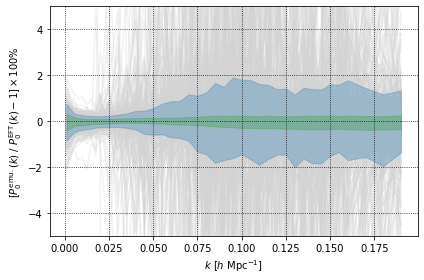

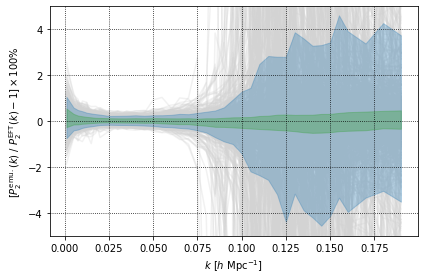

In [8]:
MatPlt.per_err(
    P0_test[:,:39], # Trim the truth as EFTEMU can't predict over full k-range.
    P0_preds,
    MatEmu.kbird[:39], # Trim k-range.
    ylim=(-5,5), # Limit to +- 5%
    xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
    ylabel=r"$[P_0^\mathrm{emu.}(k) \ / \ P_0^\mathrm{EFT}(k)-1] \times 100\%$"
)

MatPlt.per_err(
    P2_test[:,:39],
    P2_preds,
    MatEmu.kbird[:39],
    ylim=(-5,5),
    xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
    ylabel=r"$[P_2^\mathrm{emu.}(k) \ / \ P_2^\mathrm{EFT}(k)-1] \times 100\%$"
)

The plots above show that there are some sets of cosmological an nuisance parameters which have a very high prediction error. However, when considering the 68% CI (the green shaded region), we that the predictions from the `EFTEMU` agree very well with the truth for both multipoles.

We can produce a very rough estimate of the average prediction error across the test set by treating the prediction error at each $k$ value to be a Gaussian distribution centred on zero and with standard deviation being the midpoint of the upper and lower limits of the 68% CI. 

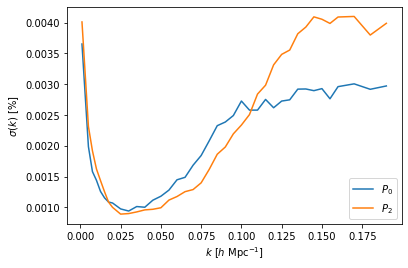

In [9]:
# Calculate upper and lower bounds of 68% CI.
P0_pred_std = np.quantile(
    (P0_test[:,:39]/P0_preds-1), # Calculate percentage error.
    [ # Define quantiles for 68% CI
        0.16,
        1-0.16
    ],
    axis=0
)

# Calculate the mid point
P0_pred_std = np.diff(P0_pred_std, axis=0)[0]/2 

P2_pred_std = np.quantile(
    (P2_test[:,:39]/P2_preds-1),
    [
        0.16,1-0.16
    ],
    axis=0)
P2_pred_std = np.diff(P2_pred_std, axis=0)[0]/2

plt.figure(1)

plt.plot(MatEmu.kbird[:39], P0_pred_std, label=r'$P_0$')
plt.plot(MatEmu.kbird[:39], P2_pred_std, label=r'$P_2$')

plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\sigma(k) \ [\%]$")

plt.legend()

plt.show()

## Inference example

To investigate how this level of prediction accuracy propgates into constraints on cosmological parameters we run an MCMC with mock $P_0$ and $P_2$ calculated using `PyBird` with the Planck 2018 $\Lambda$CDM cosmology and 'reasonable' nuisance parameters (see section 4.1 of Donald-McCann et al. [2022](https://academic.oup.com/mnras/article/518/2/3106/6831642?login=false)).

In [10]:
# Load the mock multipoles.
P0_true = np.load(data_dir+"P18/z0.61/poles/P0_P18--z-0.61_optiresum-False.npy")[1]
P2_true = np.load(data_dir+"P18/z0.61/poles/P2_P18--z-0.61_optiresum-False.npy")[1]
klin = np.load(data_dir+"P18/z0.61/poles/P2_P18--z-0.61_optiresum-False.npy")[0]

# Define true cosmology
cosmo_true = np.array([
    0.11933, # w_c
    0.02242, # w_b
    0.6766, # h
    3.047, # ln(10^10 A_s)
    0.9665 # n_s
])

# Define true nuisance parameters
bs_CMASS = np.array([
    2.22, # b1
    1.2, # c2
    0.1, # b3
    0.0, # c4
    0.4, # cct
    -7.7, # cr1
    0., # cr2
    0., # ce1
    0., # cmono
    -3.7 # cquad
])

# Define numver density associated to the mock.
ng = 4.5e-4

Before running our MCMC we can make predictions with the emulators and the true parameters.

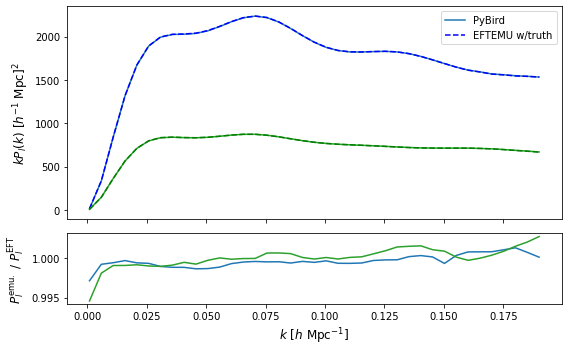

In [11]:
# EFTEMU expectes b2 and b4 as input rather than c2 and c4
def c_to_b(c2, c4):
    '''
    Convert c2 and c4 to b2 and b4.
    
    Args:
        c2 (float) : Value of c2.
        c4 (float) : Value of c4
    '''
    return np.array([1/np.sqrt(2)*(c2+c4),1/np.sqrt(2)*(c2-c4)])

bs_CMASS_mod = np.copy(bs_CMASS)
bs_CMASS_mod[[1,3]] = c_to_b(bs_CMASS[1], bs_CMASS[3])

P0_true_pred = P0_emu.emu_predict(
    cosmo_true.reshape(1,-1), # Reshape as EFTEMU expectes 2d input
    bs_CMASS_mod[:7].reshape(1,-1), 
    stochastic=bs_CMASS_mod[7:].reshape(1,-1),
    ng=ng,
    kvals=klin
)[0]
P2_true_pred = P2_emu.emu_predict(
    cosmo_true.reshape(1,-1),
    bs_CMASS_mod[:7].reshape(1,-1), 
    stochastic=bs_CMASS_mod[7:].reshape(1,-1),
    ng=ng,
    kvals=klin
)[0]

# Define figure
fig, ax = plt.subplots(
    2, # nrow
    1, # ncol
    sharex=True,
    figsize=(8,5),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)

# Upper plot
ax[0].plot( # Plot true P0
    klin,
    klin*P0_true,
    color="tab:blue",
    label="PyBird"
)
ax[0].plot( # Plot predicted P0
    klin,
    klin*P0_true_pred,
    color="blue",
    linestyle='--',
    label="EFTEMU w/truth"
)
ax[0].plot( # Plot true P2
    klin,
    klin*P2_true,
    color="tab:green"
)
ax[0].plot( # Plot predicted P2
    klin,
    klin*P2_true_pred,
    color="green",
    linestyle='--'
)

# Lower plot
ax[1].plot(
    klin,
    P0_true/P0_true_pred,
    color="tab:blue"
)
ax[1].plot(
    klin,
    P2_true/P2_true_pred,
    color="tab:green"
)

ax[1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize='large')
ax[0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize='large')
ax[1].set_ylabel(r'$P_l^\mathrm{emu.} \ / \ P_l^\mathrm{EFT}$',fontsize='large')

ax[0].legend()

plt.tight_layout()

plt.show()

We will be running our MCMC with [zeus](https://zeus-mcmc.readthedocs.io/en/latest/index.html). Below we define the functions that form the log probabolity that we will pass to `zeus`.

Note that we will be using $c_2$ and $c_4$ rather than $b_2$ and $b_4$, this is following D'Amico et al. ([2019](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005)) (see section 3.5).

In [12]:
def log_prior(theta, ng, cosmo_bounds):
    '''
    Evaluate the log prior.
    
    Args:
        theta (array) : Array containing ``n_samples`` sets of paramaeters for which the prior should be evaluated.
        ng (float): Number density.
        cosmo_bounds (array) : The hard bounds defining the training space of the ``EFTEMU``.
    '''
    # Oc, Ob, h, As, ns
    cosmo = theta[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = theta[:,5:12]
    # ce1, cmono, cquad
    stoch = theta[:,12:]
    
    # Evaluate uniform prior on cosmo params.
    box_cosmo = np.greater(cosmo[:, 0], cosmo_bounds[0,0]) & np.less(cosmo[:, 0], cosmo_bounds[0,1]) \
        & np.greater(cosmo[:, 1], cosmo_bounds[1,0]) & np.less(cosmo[:, 1], cosmo_bounds[1,1]) \
        & np.greater(cosmo[:, 2], cosmo_bounds[2,0]) & np.less(cosmo[:, 2], cosmo_bounds[2,1])\
        & np.greater(cosmo[:, 3], cosmo_bounds[3,0]) & np.less(cosmo[:, 3], cosmo_bounds[3,1])\
        & np.greater(cosmo[:, 4], cosmo_bounds[4,0]) & np.less(cosmo[:, 4], cosmo_bounds[4,1])
    
    box_bias = np.greater(bias[:, 0], 0.) & np.less(bias[:, 0], 4.) \
        & np.greater(bias[:, 1], -4.) & np.less(bias[:, 1], 4.)
    
    return np.where(box_cosmo, 0, -np.inf)+np.where(box_bias, 0, -np.inf)\
           +norm.logpdf(bias[:,2], loc=0, scale=2)\
           +norm.logpdf(bias[:,3], loc=0, scale=2)\
           +norm.logpdf(bias[:,4], loc=0, scale=2)\
           +norm.logpdf(bias[:,5], loc=0, scale=8)\
           +norm.logpdf(bias[:,6], loc=0, scale=4)\
           +norm.logpdf(stoch[:,0]/ng, loc=0, scale=400)\
           +norm.logpdf(stoch[:,1], loc=0, scale=2)\
           +norm.logpdf(stoch[:,2], loc=0, scale=2)

def log_like(theta, obs, kobs, ng, err):
    '''
    Evaluate the log likelohood.
    
    Args:
        theta (array) : Array containing ``n_samples`` sets of paramaeters for which the likelihood should be
         evaluated.
        obs (array) : The multipoles from which parameters will be infered.
         Should be concatination of P_0 and P_2.
        kobs (array) : k-values for the multipoles in ``obs``.
        ng (float): Number density.
        err (array) : The average prediction error from the ``EFTEMU``.
         Should be concatination of the error on P_0 and P_2.
    '''
    # Oc, Ob, h, As, ns
    cosmo = theta[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = theta[:,5:12]
    # ce1, cmono, cquad
    stoch = theta[:,12:]
    
    
    c2 = np.copy(bias[:,1])
    c4 = np.copy(bias[:,3])
    
    bias[:,1] = (c2+c4)/np.sqrt(2)
    bias[:,3] = (c2-c4)/np.sqrt(2)
            
    P0_pred = P0_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng, kvals=kobs)
    P2_pred = P2_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng, kvals=kobs)
    
    pred = np.hstack([P0_pred, P2_pred])
    
    return -0.5*np.sum(((pred-obs)/(err*pred))**2, axis=1)

def log_prob(theta, obs, kobs, ng, err, cosmo_bounds):
    '''
    Evaluate the log posterior.
    
    Args:
        theta (array) : Array containing ``n_samples`` sets of paramaeters for which the likelihood should be
         evaluated.
        obs (array) : The multipoles from which parameters will be infered.
         Should be concatination of P_0 and P_2.
        kobs (array) : k-values for the multipoles in ``obs``.
        ng (float): Number density.
        err (array) : The average prediction error from the ``EFTEMU``.
         Should be concatination of the error on P_0 and P_2.
        cosmo_bounds (array) : The hard bounds defining the training space of the ``EFTEMU``.
    '''
    theta = np.vstack(theta)
    lp = log_prior(theta, ng, cosmo_bounds)
    ll = log_like(theta, obs, kobs, ng, err)
    return ll+lp

def neg_log_prob(theta, obs, kobs, ng, err, cosmo_bounds):
    '''
    Evaluate the negative log posterior.
    
    Args:
        theta (array) : Array containing ``n_samples`` sets of paramaeters for which the likelihood should be
         evaluated.
        obs (array) : The multipoles from which parameters will be infered.
         Should be concatination of P_0 and P_2.
        kobs (array) : k-values for the multipoles in ``obs``.
        ng (float): Number density.
        err (array) : The average prediction error from the ``EFTEMU``.
         Should be concatination of the error on P_0 and P_2.
        cosmo_bounds (array) : The hard bounds defining the training space of the ``EFTEMU``.
    '''
    theta = np.array(theta).reshape(1, -1)
    return -(log_prob(theta, obs, kobs, ng, err, cosmo_bounds))

When carrying out inference with `zeus`, we initalise the walkers around the MAP. To calculate the MAP we minimise the negative log posterior.

In [13]:
# Extract hard bounds on cosmological parameters from the EFTEMU
emu_bounds = np.stack([
    P0_emu.P11.scalers[0].min_val, # Lower bound for all parameters
    P0_emu.P11.scalers[0].min_val+P0_emu.P11.scalers[0].diff # Sum of lower bound and range.
]).T

# Define an inital guess for the parameters that is equivalent to small perturbations from the truth.
init_guess = np.concatenate([cosmo_true, bs_CMASS])
init_guess += 1e-3*np.random.randn(len(init_guess), )

# Concatenate the true multipoles
obs_pow = np.hstack([P0_true, P2_true])

# Concatenate the average percentage error for the two multipoles
err = np.hstack([P0_pred_std, P2_pred_std])

# minimise neglogprob
results = minimize(
    neg_log_prob,
    init_guess,
    args=(
        obs_pow,
        klin,
        ng,
        err,
        emu_bounds
    ),
    options={
        'disp': True,
        "maxiter": 100000
    },
    method='Nelder-Mead'
)

Optimization terminated successfully.
         Current function value: 24.262603
         Iterations: 1247
         Function evaluations: 1802


Now we run the MCMC.

In [14]:
# Number of walkers for zeus.
nwalk = results.x.shape[0]*2

# Total number of dimensions for zeus
ndim = results.x.shape[0]

# Inital position of walkers as perturbations around MAP
# When perturbing from the truth for initial guess when calculating MAP we didn't think too much about this.
# However, poorly initalised walkers can increase time to reach convergence.
# We put a but more effort to initalise properly in this case.
# Ideally the perturbation from the map would match the standard deviation of the posterior.
# As we don't know this a priori we base the level of perturbation on the scale of the parmater.

# List of ids for each parameter that we can modify
param_ids = np.arange(15).tolist()

# Start with the same level of pertubation for all parameters
init_pos = results.x+1e-4*np.random.randn(nwalk, ndim)

# Remove w_b from id list
del param_ids[1]

# Add increased lebel of perturbation for remaining params
init_pos[:,param_ids] +=1e-3*np.random.randn(nwalk, ndim-1)

# Remove w_c, h, and ns
del param_ids[0]
del param_ids[2]
del param_ids[4]

# Add increased lebel of perturbation for remaining params
init_pos[:,param_ids] +=1e-3*np.random.randn(nwalk, ndim-4)

# Define callbacks to monitor sampling.
cb0 = zeus.callbacks.AutocorrelationCallback(
    ncheck=100, # How often to check
    dact=0.01, # Convergence threshold for tau
    nact=50, # How many tau before termination.
    discard=0.5 # How much of the chain to discard when calculating
)
cb1 = zeus.callbacks.MinIterCallback(nmin=1000)

# Define sampler
sampler = zeus.EnsembleSampler(
    nwalk,
    ndim,
    log_prob,
    args=(
        obs_pow,
        klin,
        ng,
        err,
        emu_bounds
    ),
    vectorize=True # EFTEMU is more efficent when making batch predictions.
)
start = time.time()
sampler.run_mcmc(
    init_pos,
    20000, # Max number of samples
    progress=True, # Display progress bar
    callbacks=[
        cb0,
        cb1
    ])
end = time.time()
print(f"{sampler.ncall} likelihood evaluations in {np.round((end-start)/60,1)} minutes.")

Initialising ensemble of 30 walkers...
Sampling progress :  32%|████████████████▉                                    | 6400/20000 [12:17<26:07,  8.68it/s]

963377 likelihood evaluations in 12.3 minutes.


When examining the results we discard the first $5\tilde{\tau}$ steps in the chain and produce trace plots for the cosmological parameters.

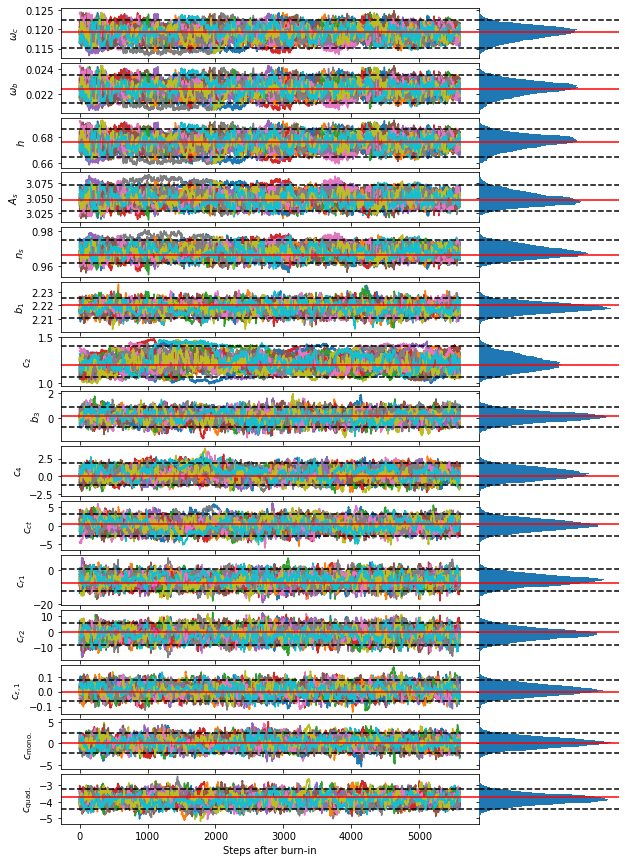

In [15]:
# Define discard length
discard = zeus.AutoCorrTime(sampler.get_chain()).mean()*5

# Extract cut chain for each walker
chain = sampler.get_chain(flat=False, discard=int(discard))

# Extract cut chain flattened across walkers
flat_chain = sampler.get_chain(flat=True, discard=int(discard))

param_labels = [
    r"$\omega_c$",
    r"$\omega_b$",
    r"$h$",
    r"$A_s$",
    r"$n_s$",
    r"$b_1$",
    r"$c_2$",
    r"$b_3$",
    r"$c_4$",
    r"$c_{ct}$",
    r"$c_{r1}$",
    r"$c_{r2}$",
    r"$c_{\epsilon,1}$",
    r"$c_\mathrm{mono.}$",
    r"$c_\mathrm{quad.}$"
]

truths = np.concatenate([cosmo_true, bs_CMASS])

fig, ax = plt.subplots(
    15, # nrow
    2, # ncol
    figsize=(10,15),
    gridspec_kw={
        'width_ratios':[3,1]
    },
    sharex='col',
    sharey='row'
)

# Loop over cosmological parameters.
for i in range(15):
    # Plot trace for each walker for ith parameter
    ax[i,0].plot(chain[:,:,i])
    
    ax[i,0].set_ylabel(param_labels[i])
    
    # Plot marginalised posterior
    ax[i,1].hist(chain[:,:,i].flatten(),bins=50, orientation='horizontal')
    
    # Make posterior look nice
    ax[i,1].set_frame_on(False)
    ax[i,1].set_xticks([])
    
    # Loop over both plots
    for j in range(2):
        # plot truth 
        ax[i,j].axhline(truths[i], color='red')
        # plot 95% CI
        for q in [0.025, 0.975]:
            ax[i,j].axhline(np.quantile(chain[:,:,i].flatten(), q), color='k', linestyle='--')

ax[-1,0].set_xlabel("Steps after burn-in")
plt.subplots_adjust(hspace=0.1, wspace=0.)
plt.show()

We can see that there is no significant bias introduced in the constraints on the cosmlogical parameters.